In [99]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [100]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Using some simple classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Some results metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix 

## Step 1 - Loading data

In [ ]:
X = np.loadtxt('Processed_Files/X_MinMaxScaler.csv', delimiter = ',')
y = np.loadtxt('Processed_Files/y_LabelEncoder.csv', delimiter = ',')

In [114]:
# Creating a train and test split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

## Step 2 - initial PCA implementation analysis (default parameters)

### Trying out PCA with its default parameters

Text(0, 0.5, 'Cumulative explained variance')

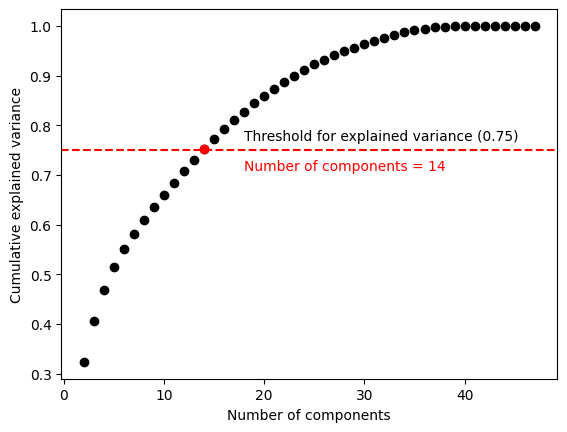

In [115]:
# Defining a threhold value for the amount of explained variance
threshold = 0.75
minimum_components = None

for i in range(2, X.shape[1]):
    
    pca = PCA(n_components = i)
    X_pca = pca.fit_transform(train_X, train_y)

    plt.plot(i, np.cumsum(pca.explained_variance_ratio_)[-1], 'ko')

    if np.cumsum(pca.explained_variance_ratio_)[-1] > threshold and minimum_components == None:
        minimum_components = i
        plt.plot(i, np.cumsum(pca.explained_variance_ratio_)[-1], 'ro')


plt.axhline(y = threshold, color = 'r', linestyle = '--')
plt.text(18, threshold + 0.02, f'Threshold for explained variance ({threshold})', fontsize = 10)
plt.text(18, threshold - 0.04, f'Number of components = {minimum_components}', fontsize = 10, color = 'r')

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')



In [116]:
# Tesing just a classifier to compare the performance between the total number of variables and the minimal reduced number of variables

# Using Logistic Regression
log_reg = LogisticRegression()

# Original dataset
log_reg.fit(train_X, train_y)
y_pred = log_reg.predict(test_X)

# Reduced pca dataset to the number of components seen previously
pca = PCA(n_components = minimum_components)
pca.fit(train_X)
X_pca_train = pca.transform(train_X)
X_pca_test = pca.transform(test_X)
log_reg.fit(X_pca_train, train_y)
y_pred_pca = log_reg.predict(X_pca_test)

# Metrics for both dastasets
f1_original = f1_score(test_y, y_pred, average = 'weighted')
f1_pca = f1_score(test_y, y_pred_pca, average = 'weighted')
print(f'F1 Score for all variables: {f1_original}')
print(f'F1 Score for {minimum_components} variables: {f1_pca}')




F1 Score for all variables: 0.9837227680533817
F1 Score for 14 variables: 0.9727230038969601


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

{'7733601262 - Failed': 0, '7733601262 - Passed': 1, '7736901286 - Failed': 2, '7736901286 - Passed': 3}


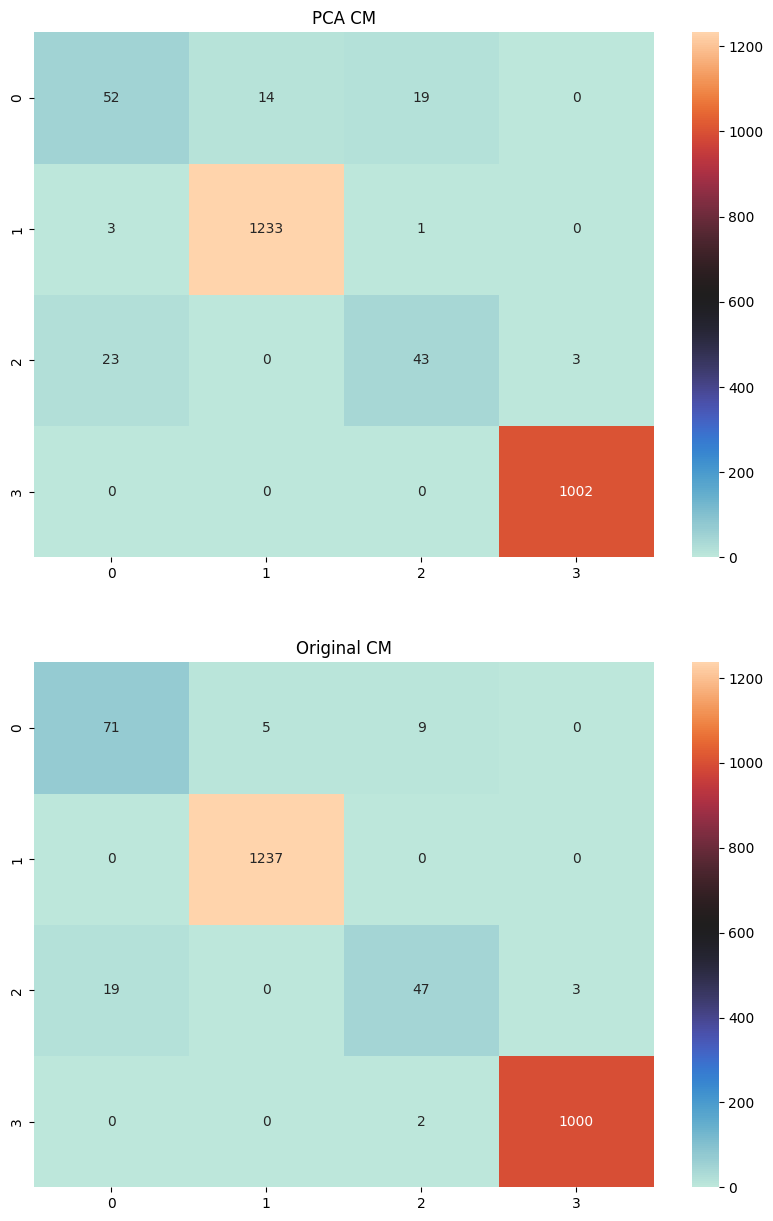

In [117]:
# Confusion matrices for both datasets
cm_pca = confusion_matrix(test_y, y_pred_pca)
cm_original = confusion_matrix(test_y, y_pred)

plt.figure(figsize = (10, 15))
plt.subplot(2, 1, 1)
sns.heatmap(cm_pca, annot=True, cmap = sns.color_palette('icefire', as_cmap = True), fmt='g')
plt.title('PCA CM')

plt.subplot(2, 1, 2)
sns.heatmap(cm_original, annot=True, cmap = sns.color_palette('icefire', as_cmap = True), fmt='g')
plt.title('Original CM')

print(y_mapping)

## Step 3 - Comparative analysis + Optimisation process

In [118]:
from skopt import BayesSearchCV, gp_minimize
import skopt
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from skopt.utils import use_named_args

In [131]:
# Step 1 - defining the hyperparameters' search space
search_space = []

search_space.append(skopt.space.Integer(2, 30, name = 'n_components'))
search_space.append(skopt.space.Categorical([True, False], name = 'whiten'))
search_space.append(skopt.space.Categorical(['auto', 'full', 'arpack', 'randomized'], name = 'svd_solver'))
search_space.append(skopt.space.Integer(1, 50, name = 'n_oversamples'))
search_space.append(skopt.space.Categorical(['auto', 'QR', 'LU', 'none'], name = 'power_iteration_normalizer'))

In [132]:
# Step 2 - defining the evaluator
@use_named_args(search_space)

def evaluate_model(**params):

    # Define the model
    model = PCA()
    model.set_params(**params)

    # Now fitting the PCA model to the training data
    model.fit(X)
    X_pca = model.transform(X)

    # Define the model to be used for the classification
    log_reg = LogisticRegression()
    
    # Define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    # Evaluate the model
    result = cross_val_score(log_reg, X_pca, y, cv = cv, n_jobs = -1, scoring = 'accuracy')

    # Return the mean accuracy
    return 1.0 - result.mean()  


In [133]:
# Step 3 - conduct optimisation process
result = gp_minimize(evaluate_model, search_space, n_calls = 1000, n_random_starts = 10, random_state = 42, verbose = 1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8988
Function value obtained: 0.0225
Current minimum: 0.0225
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3274
Function value obtained: 0.0298
Current minimum: 0.0225
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2225
Function value obtained: 0.0325
Current minimum: 0.0225
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8827
Function value obtained: 0.0262
Current minimum: 0.0225
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.7058
Function value obtained: 0.0257
Current minimum: 0.0225
Iteration No: 6 started. Evaluating

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.6450
Function value obtained: 0.0198
Current minimum: 0.0197
Iteration No: 36 started. Searching for the next optimal point.


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.6242
Function value obtained: 0.0203
Current minimum: 0.0197
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.7142
Function value obtained: 0.0302
Current minimum: 0.0197
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.5368
Function value obtained: 0.0412
Current minimum: 0.0197
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.4051
Function value obtained: 0.0255
Current minimum: 0.0197
Iteration No: 40 started. Searching for the next optimal point.
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.3916
Function value obtained: 0.0217
Current minimum: 0.0197
Iteration No: 41 started. Sea

In [141]:
# Analysing the best gotten parameters
result.x

[29, False, 'randomized', 1, 'LU']

Using the best parameters achieved by the hyperaparameter optimisation, and comparing those to the original set of variables

In [144]:
# Using Logistic Regression
log_reg = LogisticRegression()

# Original dataset
log_reg.fit(train_X, train_y)
y_pred = log_reg.predict(test_X)

# Reduced pca dataset to the number of components seen previously
pca = PCA(n_components = result.x[0], whiten = result.x[1], svd_solver = result.x[2], n_oversamples = result.x[3], power_iteration_normalizer = result.x[4])
pca.fit(train_X)
X_pca_train = pca.transform(train_X)
X_pca_test = pca.transform(test_X)
log_reg.fit(X_pca_train, train_y)
y_pred_pca = log_reg.predict(X_pca_test)

# Metrics for both dastasets
f1_original = f1_score(test_y, y_pred, average = 'weighted')
f1_pca = f1_score(test_y, y_pred_pca, average = 'weighted')
print(f'F1 Score for all variables: {f1_original}')
print(f'F1 Score for {minimum_components} variables: {f1_pca}')

F1 Score for all variables: 0.9837227680533817
F1 Score for 14 variables: 0.9776481179233966


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

## Step 4 - Comparing the performance for multiple classifiers - reduced data + original size

In [145]:
# Loading each classifier (with their default hyperparameters)
svm = SVC()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
nb = GaussianNB()
log_reg = LogisticRegression()

In [150]:
# Fitting and applying all classifiers to the original sized dataset
svm.fit(train_X, train_y)
rf.fit(train_X, train_y)
gb.fit(train_X, train_y)
nb.fit(train_X, train_y)
log_reg.fit(train_X, train_y)

# Predicting the results of the test set
y_pred_svm = svm.predict(test_X)
y_pred_rf = rf.predict(test_X)
y_pred_gb = gb.predict(test_X)
y_pred_nb = nb.predict(test_X)
y_pred_log_reg = log_reg.predict(test_X)

# Calculating the metrics for each classifier
f1_svm = f1_score(test_y, y_pred_svm, average = 'weighted')
f1_rf = f1_score(test_y, y_pred_rf, average = 'weighted')
f1_gb = f1_score(test_y, y_pred_gb, average = 'weighted')
f1_nb = f1_score(test_y, y_pred_nb, average = 'weighted')
f1_log_reg = f1_score(test_y, y_pred_log_reg, average = 'weighted')

# Storing the metrics under a dataframe
metrics = pd.DataFrame(columns = ['N_vars', 'SVM', 'RF', 'GB', 'NB', 'LogReg'])
metrics.loc[0] = ['All', f1_svm, f1_rf, f1_gb, f1_nb, f1_log_reg]

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [151]:
# Fitting and applying all classifiers to the reduced dataset
svm.fit(X_pca_train, train_y)
rf.fit(X_pca_train, train_y)
gb.fit(X_pca_train, train_y)
nb.fit(X_pca_train, train_y)
log_reg.fit(X_pca_train, train_y)

# Predicting the results of the test set
y_pred_svm_pca = svm.predict(X_pca_test)
y_pred_rf_pca = rf.predict(X_pca_test)
y_pred_gb_pca = gb.predict(X_pca_test)
y_pred_nb_pca = nb.predict(X_pca_test)
y_pred_log_reg_pca = log_reg.predict(X_pca_test)

# Calculating the metrics for each classifier
f1_svm_pca = f1_score(test_y, y_pred_svm_pca, average = 'weighted')
f1_rf_pca = f1_score(test_y, y_pred_rf_pca, average = 'weighted')
f1_gb_pca = f1_score(test_y, y_pred_gb_pca, average = 'weighted')
f1_nb_pca = f1_score(test_y, y_pred_nb_pca, average = 'weighted')
f1_log_reg_pca = f1_score(test_y, y_pred_log_reg_pca, average = 'weighted')

# Storing the metrics under a dataframe
metrics.loc[1] = [result.x[0], f1_svm_pca, f1_rf_pca, f1_gb_pca, f1_nb_pca, f1_log_reg_pca]

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [152]:
metrics

,N_vars,SVM,RF,GB,NB,LogReg
0,All,0.975198,0.988554,0.990248,0.978652,0.983723
1,29.0,0.972619,0.978197,0.976741,0.950830,0.977648
